In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
# from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

torch.cuda.empty_cache()


In [3]:
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn import preprocessing

from notebooks.imports import *
from config import dir_config
from src.utils.glm_hmm_utils import *
import pickle
import copy

In [4]:
from src.bayesian_encoding.model import Net
from src.bayesian_encoding.utils import set_seed

### Config

In [5]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

In [6]:
session_metadata = pd.read_csv(Path(compiled_dir, "sessions_metadata.csv"))
session_metadata = session_metadata[session_metadata["session_id"] != "241209_GP_TZ"]  # remove session with no trials in biased state coh 6 awayRF choice condition

neuron_metadata = pd.read_csv(Path(compiled_dir, "neuron_metadata.csv"))

with open(Path(processed_dir, "glm_hmm_all_trials_prior_based_initialization_final.pkl"), "rb") as f:
	glm_hmm = pickle.load(f)

with open(Path(processed_dir, "ephys_neuron_wise.pkl"), "rb") as f:
	ephys = pickle.load(f)

In [7]:
coh = [-50, -20, -6, 0, 6, 20, 50]

equal_prior = np.array([0.125, .125, .125, .25, .125, .125, .125])
toRF_prior = np.array([0.075, 0.075, 0.075, 0.25, 0.175, 0.175, 0.175])
awayRF_prior = np.array([0.175, 0.175, 0.175, 0.25, 0.075, 0.075, 0.075])

### Helper Functions

In [8]:
def get_session_neural_data(epoch, valid_trial_filter, neuron_ids):
	"""return 3d array of shape (num_neurons, num_trials, num_time_bins)"""
	neural_data = []
	for neuron_id in neuron_ids:
		neural_data.append(ephys[epoch][neuron_id]['convolved_spike_trains'])
	neural_data = np.array(neural_data)
	neural_data = neural_data[:, valid_trial_filter, :]
	return neural_data


#### Getting test session data

In [79]:
session_id = "241223_GP_TZ"
epoch = "response_onset"

trial_data = glm_hmm['session_wise']['data'][session_id]
valid_trial_filter = np.where((trial_data['mask'] == 1) & (~np.isnan(trial_data['reaction_time'])))[0]
trial_data = trial_data.iloc[valid_trial_filter]
neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
neural_data = get_session_neural_data(epoch=epoch, valid_trial_filter=valid_trial_filter, neuron_ids=neuron_ids)

prior_direction = session_metadata[session_metadata["session_id"] == session_id].prior_direction.values[0]
prior = np.empty((trial_data.shape[0], len(coh)))
eq_idx = np.where(trial_data['prob_toRF'] == 50)[0]
uneq_idx = np.where(trial_data['prob_toRF'] != 50)[0]
prior[eq_idx] = equal_prior
if prior_direction == "toRF":
    prior[uneq_idx] = toRF_prior
elif prior_direction == "awayRF":
	prior[uneq_idx] = awayRF_prior


---

In [80]:
net = Net(n_channel=neural_data.shape[0], n_output=len(coh), std=0.001, dropout=0.5)
net.cuda()
loss = nn.CrossEntropyLoss().cuda()
net.eval()

Net(
  (hiddens): Sequential(
    (0): Linear(in_features=7, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (ro_layer): Linear(in_features=100, out_features=7, bias=True)
)

In [112]:
unique_stimuli = trial_data['stimulus'].unique()
stim_map = {stim: i for i, stim in enumerate(np.sort(unique_stimuli))}

x = torch.tensor(np.nansum(neural_data[:, :, 200:300], axis=2).T, dtype=torch.float32, device="cuda")
t = torch.tensor([stim_map[stim] for stim in trial_data['stimulus'].values], dtype=torch.long, device="cuda")
prior = torch.tensor(prior, dtype=torch.float32, device="cuda")

3.44416400432261


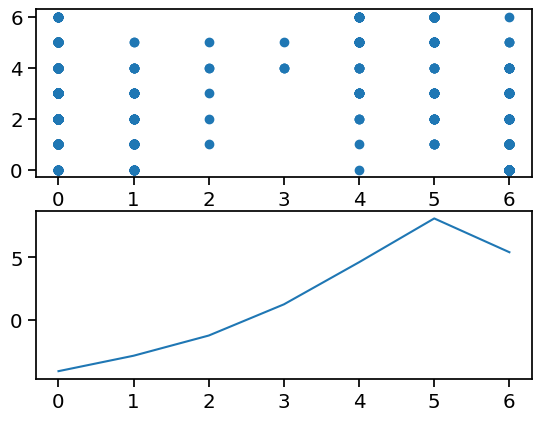

In [113]:
delta = 1
net.eval()
y = net(x)
y = y + prior
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, t.cpu().numpy())

print(np.sqrt(np.mean((t_hat - t.cpu().numpy())**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

In [120]:
net.std = 1e-2
set_seed(8)
net.initialize()
torch.autograd.set_detect_anomaly(True)

# Learning rates
alpha = 1  # Reduce regularization term
learning_rates = 0.003 * 3.0**(-np.arange(3))  # Reduced learning rates

for lr in learning_rates:
    print('\n\n\n\n LEARNING RATE: {}'.format(lr))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)

    for epoch in range(1000):
        net.train()
        optimizer.zero_grad()

        y = net(x)

        # Check for NaNs in output
        if torch.isnan(y).any() or torch.isinf(y).any():
            print(f"NaNs or Infs detected in output y at epoch {epoch}")
            print(f"Output y range: min={y.min()}, max={y.max()}, mean={y.mean()}")
            break

        post = y + prior
        post = post - post.max(1, keepdim=True)[0]  # Stabilize softmax

        # Check for NaNs in post
        if torch.isnan(post).any() or torch.isinf(post).any():
            print(f"NaNs or Infs detected in post at epoch {epoch}")
            break

        conv_filter = torch.tensor([-0.25, 0.5, -0.25], dtype=torch.float32, device="cuda").reshape(1, 1, -1)
        smoothness = nn.functional.conv1d(y.unsqueeze(1), conv_filter).pow(2).mean()

        score = loss(post, t) + alpha * smoothness

        # Check for NaNs in loss score
        if torch.isnan(score).any() or torch.isinf(score).any():
            print(f"NaNs or Infs detected in loss at epoch {epoch}")
            break

        score.backward()

        # Check gradients for NaNs
        for param in net.parameters():
            if torch.isnan(param.grad).any():
                print("NaNs detected in gradients")
                break

        # # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)  # You can experiment with max_norm

        optimizer.step()

        if epoch % 100 == 0:
            print(f'Score: {score.item()}')


Setting numpy and torch seed to 8




 LEARNING RATE: 0.003
Score: 137.99136352539062
Score: 2.2926671504974365
Score: 1.8238056898117065
Score: 1.6319875717163086
Score: 1.5790804624557495
Score: 1.5924277305603027
Score: 1.5689871311187744
Score: 1.5630946159362793
Score: 1.5531730651855469
Score: 1.5542566776275635




 LEARNING RATE: 0.001
Score: 1.5388031005859375
Score: 1.5249818563461304
Score: 1.5314091444015503
Score: 1.5375936031341553
Score: 1.5377384424209595
Score: 1.5494885444641113
Score: 1.5534675121307373
Score: 1.5413970947265625
Score: 1.5429883003234863
Score: 1.5310112237930298




 LEARNING RATE: 0.0003333333333333333
Score: 1.5307451486587524
Score: 1.523471474647522
Score: 1.526908040046692
Score: 1.532950520515442
Score: 1.520775318145752
Score: 1.5284638404846191
Score: 1.5221335887908936
Score: 1.5148197412490845
Score: 1.515194058418274
Score: 1.5289088487625122


In [121]:
def objective(net, x=None, t=None):
	if x is None and t is None:
		return None
	net.eval()
	y = net(x)
	posterior = y + prior
	_, loc = torch.max(posterior, dim=1)
	v =(t.double() - loc.double()).pow(2).mean().sqrt() * delta
	return v.data.cpu().numpy()

objective(net, x=x, t=t)

array(1.48916215)

In [122]:
nbins = 7
pv = (np.arange(nbins) - nbins//2) * delta
t_ = t.cuda().cpu().numpy()

In [138]:
pv

array([-3, -2, -1,  0,  1,  2,  3])

In [137]:
t[11]

tensor(6, device='cuda:0')

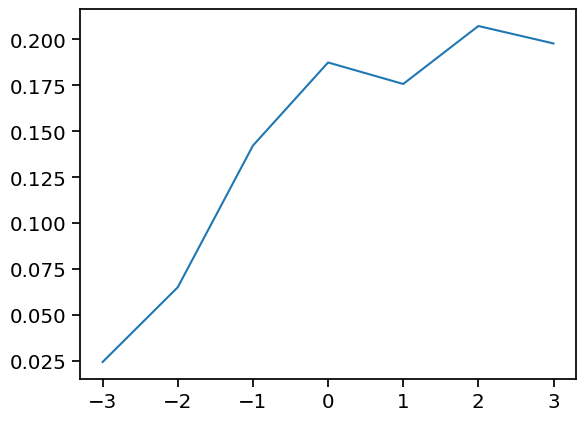

In [133]:
plt.plot(pv, yd[11])

Text(0.5, 0.98, '$\\mathbf{E}[\\sigma]$=1.599')

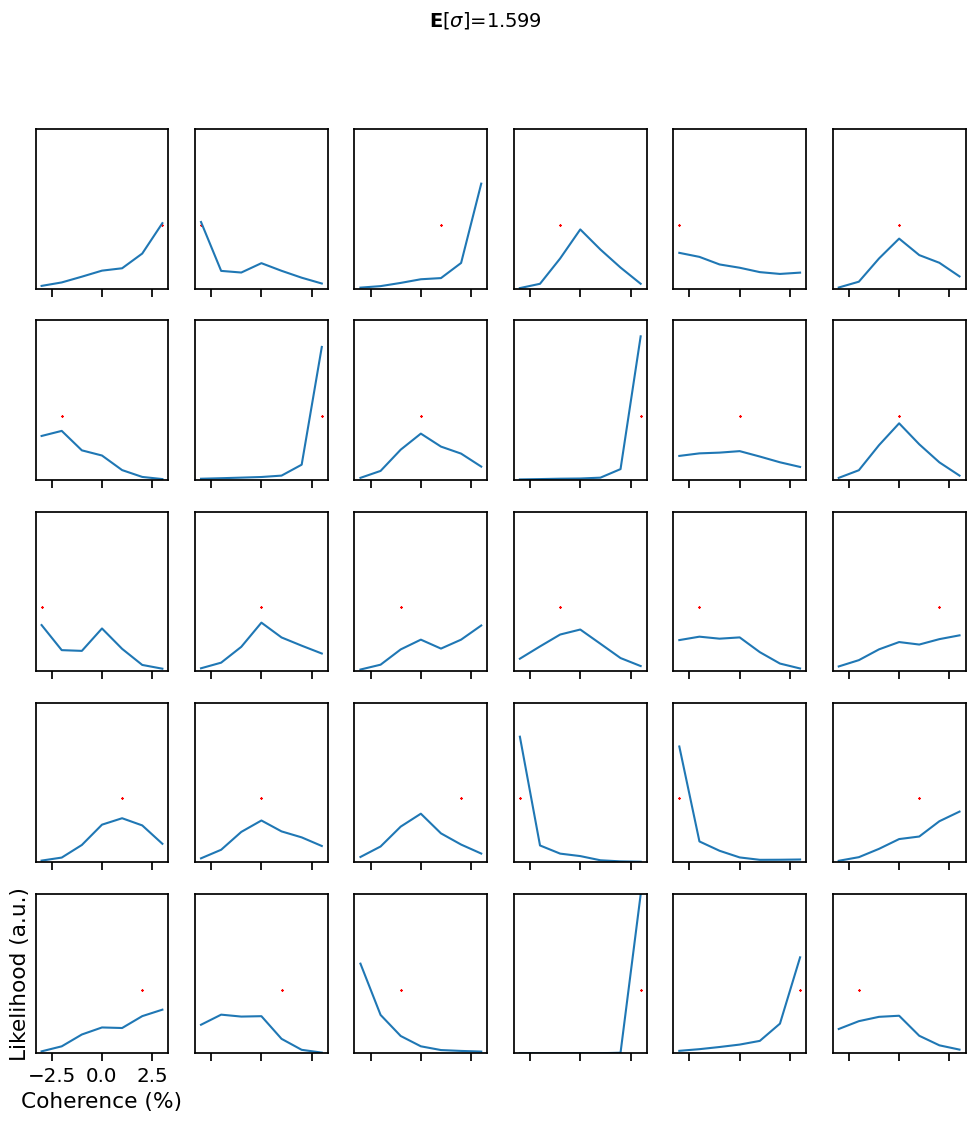

In [ ]:

from itertools import count

y = net(x)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta

n_rows = 5
n_cols = 6
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

for c, ((i, j), ax) in zip(count(), np.ndenumerate(axs)):
    c = c+20

    ax.plot(pv, yd[c])
    ax.scatter(pv[t_[c]],0.4, color='red', marker='x', s=1)
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ax.set_ylabel('Likelihood (a.u.)')
        ax.set_xlabel('Coherence (%)')#($^\circ$)')
    else:
        ax.set_xticklabels([])

fig.suptitle("$\mathbf{{E}}[\sigma]$={:0.3f}".format(avg_sigma), fontsize=14)